# Detecção de Fraudes com Modelos Baseados em Árvores de Decisão - DecisionTree e Ensembles

# Resumo

# Importando as Bibliotecas

In [ ]:
# Manipulação de Dados
import pandas as pd
import numpy as np
import json
import joblib

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Modelagem e Avaliação
import sklearn
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier
)
from xgboost import XGBClassifier
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    learning_curve
)

import time

# Métricas e Avaliação
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    make_scorer,
    precision_recall_curve,
    average_precision_score
)

from sklearn.base import clone


# Otimização Bayesiana
from skopt import BayesSearchCV
from skopt.space import Integer, Real

# Funções Auxiliares
import utils.aux_func as af
from utils.paths import (
    SPLITS_DIR,
    ANCHOR_ARTIFACTS_DIR,
    METRIC_ARTIFACTS_DIR
)
from evaluation.business_metric import business_metric


# Configurações Gerais
import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.dpi"] = 400
pd.set_option("display.max_columns", None)

# Importando a Base

In [4]:
df_train = pd.read_parquet(SPLITS_DIR / "train.parquet")
df_val   = pd.read_parquet(SPLITS_DIR / "val.parquet")
df_test  = pd.read_parquet(SPLITS_DIR / "test.parquet")

def unpack(df):
    X = df.drop(columns=["target", "amount"])
    y = df["target"]
    amount = df["amount"]
    return X, y, amount

X_train, y_train, amount_train = unpack(df_train)
X_val, y_val, amount_val = unpack(df_val)
X_test, y_test, amount_test = unpack(df_test)


# Importando a Métrica de Negócio

In [13]:
with open(METRIC_ARTIFACTS_DIR / "business_metric_config.json") as f:
    metric_cfg = json.load(f)

metric_params = {
    "gain_legitimate_accept_rate": metric_cfg["gain_legitimate_accept_rate"],
    "gain_fraud_refuse": metric_cfg["gain_fraud_refuse"],
    "loss_legitimate_refuse": metric_cfg["loss_legitimate_refuse"],
}

sklearn.set_config(enable_metadata_routing=True)

business_scorer = (
    make_scorer(
        business_metric,
        **metric_params
    )
    .set_score_request(amount=True)
)

# Baseline Econômico: Sempre Aprovar as Transações (Always Accept Policy)

Essa política representa um cenário em que nenhuma transação é recusada, independentemente de seu risco. Na prática, ela equivale à ausência completa de um sistema antifraude. Ela acceita todas as transações legítimas e fraudulentas, gerando perdas financeiras proporcionais ao valor das fraudes. Além disso, não há custos associados à recusa indevida de clientes legítimos nem ganhos provenientes de detecção de fraudes.

In [14]:
always_accept_policy = DummyClassifier(strategy="constant", constant=0)
always_accept_policy.fit(X_train, y_train)

benefit_accept = business_scorer(
    always_accept_policy,
    X_test,
    y_test,
    amount=amount_test
)

print(f"O benefício da politica de sempre aceitar as transações é de: {benefit_accept:,.2f}€")

O benefício da politica de sempre aceitar as transações é de: 90,280.45€


# Modelo Ancora Logit

In [8]:
logit_anchor = joblib.load(
    ANCHOR_ARTIFACTS_DIR / "logit_anchor.joblib"
)

with open(ANCHOR_ARTIFACTS_DIR / "threshold.json") as f:
    anchor_threshold = json.load(f)["optimal_threshold"]


In [49]:
y_score_anchor = logit_anchor.predict_proba(X_test)[:, 1]
y_pred_anchor = (y_score_anchor >= anchor_threshold).astype(int)

with open(ANCHOR_ARTIFACTS_DIR / "threshold.json") as f:
    business_test_opt = json.load(f)["business_metric"]

# Modelos baseados em Árvores de Decisão

In [15]:
modelos = {
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "GradientBoost": GradientBoostingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric="logloss", random_state=42)
}

## Seleção de Modelo

In [16]:
resultados_economicos = []
resultados_metricas   = []

In [19]:
for nome, modelo in modelos.items():
    print(f"Avaliando modelo: {nome}")

    # Clonar modelo para evitar efeitos colaterais
    clf = clone(modelo)

    # ======================
    # (1) Treinamento
    # ======================
    clf.fit(X_train, y_train)

    # ======================
    # (2) Predições
    # ======================
    y_proba_val = clf.predict_proba(X_val)[:, 1]
    y_proba_test = clf.predict_proba(X_test)[:, 1]

    # Threshold fixo nesta fase (ex: 0.5)
    thr = 0.5

    y_pred_val  = (y_proba_val  >= thr).astype(int)
    y_pred_test = (y_proba_test >= thr).astype(int)

    # ======================
    # (3) Métrica de negócio
    # ======================
    business_val = business_metric(
        y_val,
        y_pred_val,
        amount_val
    )

    business_test = business_metric(
        y_test,
        y_pred_test,
        amount_test
    )

    resultados_economicos.append({
        "Modelo": nome,
        "Threshold": thr,
        "Business_Val (€)": business_val,
        "Business_Test (€)": business_test
    })

    # ======================
    # (4) Métricas tradicionais
    # ======================
    desempenho = af.calcula_desempenho(
        clf,
        X_train, y_train,
        X_test, y_test
    )

    desempenho["Modelo"] = nome
    resultados_metricas.append(desempenho)


Avaliando modelo: DecisionTree
Avaliando modelo: RandomForest
Avaliando modelo: GradientBoost
Avaliando modelo: AdaBoost
Avaliando modelo: XGBoost


In [20]:
df_business = pd.DataFrame(resultados_economicos)
df_business


Modelo  Threshold  Business_Val (€)  Business_Test (€)
0   DecisionTree        0.5      98015.989746      100665.179443
1   RandomForest        0.5      99401.298340      101444.738770
2  GradientBoost        0.5      91619.276367       91014.980469
3       AdaBoost        0.5      98335.474121      100169.443359
4        XGBoost        0.5      96873.388672      100584.870117

In [21]:
df_metricas = pd.concat(resultados_metricas, axis=0)
df_metricas = df_metricas.reset_index().rename(columns={"index": "Métrica"})
df_metricas

Métrica    Treino     Teste  Variação         Modelo
0    Acurácia  1.000000  0.999263     -0.00   DecisionTree
1      AUCROC  1.000000  0.883671     -0.12   DecisionTree
2          KS  1.000000  0.767343     -0.23   DecisionTree
3   Precision  1.000000  0.800000     -0.20   DecisionTree
4      Recall  1.000000  0.767677     -0.23   DecisionTree
5          F1  1.000000  0.783505     -0.22   DecisionTree
6    Acurácia  1.000000  0.999631     -0.00   RandomForest
7      AUCROC  1.000000  0.948110     -0.05   RandomForest
8          KS  1.000000  0.882540     -0.12   RandomForest
9   Precision  1.000000  0.953488     -0.05   RandomForest
10     Recall  1.000000  0.828283     -0.17   RandomForest
11         F1  1.000000  0.886486     -0.11   RandomForest
12   Acurácia  0.998455  0.998367     -0.00  GradientBoost
13     AUCROC  0.322002  0.297950     -0.07  GradientBoost
14         KS  0.603179  0.636100      0.05  GradientBoost
15  Precision  0.712329  0.636364     -0.11  GradientBoost
16     Recall  0.176271  0.141414     -0.20  GradientBoost
17         F1  0.282609  0.231405     -0.18  GradientBoost
18   Acurácia  0.999245  0.999157     -0.00       AdaBoost
19     AUCROC  0.995105  0.970485     -0.02       AdaBoost
20         KS  0.922074  0.879887     -0.05       AdaBoost
21  Precision  0.814394  0.793103     -0.03       AdaBoost
22     Recall  0.728814  0.696970     -0.04       AdaBoost
23         F1  0.769231  0.741935     -0.04       AdaBoost
24   Acurácia  1.000000  0.999350     -0.00        XGBoost
25     AUCROC  1.000000  0.919114     -0.08        XGBoost
26         KS  1.000000  0.831286     -0.17        XGBoost
27  Precision  1.000000  0.887500     -0.11        XGBoost
28     Recall  1.000000  0.717172     -0.28        XGBoost
29         F1  1.000000  0.793296     -0.21        XGBoost

In [22]:
# Transformando os DataFrames
# Treino
desemp_treino = pd.pivot(
    data=df_metricas,
    index="Modelo",
    columns='Métrica',
    values='Treino'
)

desemp_treino.rename(columns={
    'AUCROC': 'AUCROC_Treino',
    'Acurácia': 'Acurácia_Treino',
    'F1':'F1_Treino',
    'KS':'KS_Treino',
    'Precision':'Precision_Treino',
    'Recall':'Recall_Treino'
}, inplace= True)

# Teste
desemp_teste = pd.pivot(
    data=df_metricas,
    index="Modelo",
    columns='Métrica',
    values='Teste'
)

desemp_teste.rename(columns={
    'AUCROC': 'AUCROC_Teste',
    'Acurácia': 'Acurácia_Teste',
    'F1': 'F1_Teste',
    'KS': 'KS_Teste',
    'Precision': 'Precision_Teste',
    'Recall': 'Recall_Teste'
}, inplace=True)

# Variação
desemp_variacao = pd.pivot(
    data=df_metricas,
    index="Modelo",
    columns='Métrica',
    values='Variação'
)

desemp_variacao.rename(columns={
    'AUCROC': 'AUCROC_Variacao',
    'Acurácia': 'Acurácia_Variacao',
    'F1': 'F1_Variacao',
    'KS': 'KS_Variacao',
    'Precision': 'Precision_Variacao',
    'Recall': 'Recall_Variacao'
}, inplace=True)

In [23]:
busca_modelo = pd.concat([desemp_treino, desemp_teste, desemp_variacao], axis=1)
busca_modelo.reset_index(inplace=True)
busca_modelo

Métrica         Modelo  AUCROC_Treino  Acurácia_Treino  F1_Treino  KS_Treino  \
0             AdaBoost       0.995105         0.999245   0.769231   0.922074   
1         DecisionTree       1.000000         1.000000   1.000000   1.000000   
2        GradientBoost       0.322002         0.998455   0.282609   0.603179   
3         RandomForest       1.000000         1.000000   1.000000   1.000000   
4              XGBoost       1.000000         1.000000   1.000000   1.000000   

Métrica  Precision_Treino  Recall_Treino  AUCROC_Teste  Acurácia_Teste  \
0                0.814394       0.728814      0.970485        0.999157   
1                1.000000       1.000000      0.883671        0.999263   
2                0.712329       0.176271      0.297950        0.998367   
3                1.000000       1.000000      0.948110        0.999631   
4                1.000000       1.000000      0.919114        0.999350   

Métrica  F1_Teste  KS_Teste  Precision_Teste  Recall_Teste  AUCROC_Variacao  \
0        0.741935  0.879887         0.793103      0.696970            -0.02   
1        0.783505  0.767343         0.800000      0.767677            -0.12   
2        0.231405  0.636100         0.636364      0.141414            -0.07   
3        0.886486  0.882540         0.953488      0.828283            -0.05   
4        0.793296  0.831286         0.887500      0.717172            -0.08   

Métrica  Acurácia_Variacao  F1_Variacao  KS_Variacao  Precision_Variacao  \
0                     -0.0        -0.04        -0.05               -0.03   
1                     -0.0        -0.22        -0.23               -0.20   
2                     -0.0        -0.18         0.05               -0.11   
3                     -0.0        -0.11        -0.12               -0.05   
4                     -0.0        -0.21        -0.17               -0.11   

Métrica  Recall_Variacao  
0                  -0.04  
1                  -0.23  
2                  -0.20  
3                  -0.17  
4                  -0.28

In [24]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: #90ee90' if v else '' for v in is_max]

best_test = desemp_teste.style.apply(highlight_max, axis=0)\
                         .set_caption("Desempenho dos Modelos no Teste – Destaque para os Melhores")
best_test

In [25]:
def highlight_min_abs(s):
    abs_vals = s.abs()                 # calcula valor absoluto
    min_abs = abs_vals.min()           # menor valor absoluto da coluna
    return ['background-color: #add8e6' if abs(v) == min_abs else '' for v in s]


train_test_var = desemp_variacao.style.apply(highlight_min_abs, axis=0)\
                         .set_caption("Variação entre Treino e Teste – Destaque para os Melhores")

train_test_var

O RandomForest se destaca como o modelo de maior desempenho absoluto, enquanto o AdaBoost emerge como uma alternativa mais conservadora, com menor variância e maior estabilidade entre treino e teste. A comparação entre ambos permite avaliar explicitamente o trade-off entre maximização de valor econômico e robustez operacional.

## Explorando os Hiperparâmetros

### Definindo o Espaço Paramétrico

In [26]:
rf_space = {
    "n_estimators": Integer(100, 400),
    "max_depth": Integer(3, 20),
    "min_samples_split": Integer(2, 100),
    "min_samples_leaf": Integer(1, 50),
    "max_features": Real(0.2, 1.0),
}



ada_space = {
    "n_estimators": Integer(50, 300),
    "learning_rate": Real(0.01, 1.0, prior="log-uniform"),
}


## Subamostragem para o BO

In [29]:
X_train_bo, _, y_train_bo, _ = train_test_split(
    X_train,
    y_train,
    test_size=0.9,       # mantém 10%
    stratify=y_train,
    random_state=42
)

X_val_bo, _, y_val_bo, _ = train_test_split(
    X_val,
    y_val,
    test_size=0.9,       # mantém 10%
    stratify=y_val,
    random_state=42
)

# índices artificiais para simular um único split
X_bo = pd.concat([X_train_bo, X_val_bo])
y_bo = pd.concat([y_train_bo, y_val_bo])

idx_train = np.arange(len(X_train_bo))
idx_val   = np.arange(len(X_train_bo), len(X_bo))

cv_split = [(idx_train, idx_val)]


### Rodando a Otimização

In [34]:
sklearn.set_config(enable_metadata_routing=False)

rf = RandomForestClassifier(
    random_state=42,
    n_jobs=1
)

bo_rf = BayesSearchCV(
    estimator=rf,
    search_spaces=rf_space,
    scoring="neg_log_loss",
    n_iter=10,
    cv=cv_split,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

bo_rf.fit(X_bo, y_bo)

print("Melhores hiperparâmetros RF:")
print(bo_rf.best_params_)
print(f"Melhor log loss (validação): {-bo_rf.best_score_:.6f}")

Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Melhores hiperparâmetros RF:
OrderedDict([('max_depth', 17), ('max_features', 0.33749724911724854), ('min_samples_leaf', 30), ('min_samples_split', 81), ('n_estimators', 257)])
Melhor log loss (validação): 0.004786


In [35]:
ada = AdaBoostClassifier(
    random_state=42
)

bo_ada = BayesSearchCV(
    estimator=ada,
    search_spaces=ada_space,
    scoring="neg_log_loss",
    n_iter=10,
    cv=cv_split,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

bo_ada.fit(X_bo, y_bo)

print("Melhores hiperparâmetros AdaBoost:")
print(bo_ada.best_params_)
print(f"Melhor log loss (validação): {-bo_ada.best_score_:.6f}")

Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Fitting 1 folds for each of 1 candidates, totalling 1 fits
Melhores hiperparâmetros AdaBoost:
OrderedDict([('learning_rate', 0.010168587136004645), ('n_estimators', 254)])
Melhor log loss (validação): 0.138643


### Congelando o Melhor modelo

In [36]:
best_rf = RandomForestClassifier(
    **bo_rf.best_params_,
    random_state=42,
    n_jobs=-1
)

best_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=17, max_features=0.33749724911724854,
                       min_samples_leaf=30, min_samples_split=81,
                       n_estimators=257, n_jobs=-1, random_state=42)

In [37]:
best_ada = AdaBoostClassifier(
    **bo_ada.best_params_,
    random_state=42
)
best_ada.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=0.010168587136004645, n_estimators=254,
                   random_state=42)

## Ajustando o Limiar de Decisão

In [38]:
sklearn.set_config(enable_metadata_routing=True)

In [39]:
y_proba_val_rf = best_rf.predict_proba(X_val)[:, 1]
y_proba_val_ada = best_ada.predict_proba(X_val)[:, 1]

In [40]:
thresholds = np.linspace(0.01, 0.99, 99)

In [41]:
business_values_rf = []

for thr in thresholds:
    y_pred_thr = (y_proba_val_rf >= thr).astype(int)
    business_values_rf.append(
        business_metric(y_val, y_pred_thr, amount_val)
    )

business_values_rf = np.array(business_values_rf)

best_idx_rf = np.argmax(business_values_rf)
best_threshold_rf = thresholds[best_idx_rf]

print(f"Threshold ótimo RF (validação): {best_threshold_rf:.3f}")
print(f"Benefício máximo (val): €{business_values_rf[best_idx_rf]:,.2f}")

Threshold ótimo RF (validação): 0.260
Benefício máximo (val): €99,823.50


In [42]:
business_values_ada = []

for thr in thresholds:
    y_pred_thr = (y_proba_val_ada >= thr).astype(int)
    business_values_ada.append(
        business_metric(y_val, y_pred_thr, amount_val)
    )

business_values_ada = np.array(business_values_ada)

best_idx_ada = np.argmax(business_values_ada)
best_threshold_ada = thresholds[best_idx_ada]

print(f"Threshold ótimo AdaBoost (validação): {best_threshold_ada:.3f}")
print(f"Benefício máximo (val): €{business_values_rf[best_idx_ada]:,.2f}")


Threshold ótimo AdaBoost (validação): 0.280
Benefício máximo (val): €99,807.66


In [43]:
y_proba_test_rf = best_rf.predict_proba(X_test)[:, 1]
y_pred_test_rf_opt = (y_proba_test_rf >= best_threshold_rf).astype(int)

business_test_rf_opt = business_metric(
    y_test,
    y_pred_test_rf_opt,
    amount_test
)

print(f"Métrica de Negócio com o Threshold Ótimo: {business_test_rf_opt:,.2f}€")

Métrica de Negócio com o Threshold Ótimo: 101,708.96€


In [44]:
y_proba_test_ada = best_ada.predict_proba(X_test)[:, 1]
y_pred_test_ada_opt = (y_proba_test_ada >= best_threshold_ada).astype(int)

business_test_ada_opt = business_metric(
    y_test,
    y_pred_test_ada_opt,
    amount_test
)

print(f"Métrica de Negócio com o Threshold Ótimo: {business_test_ada_opt:,.2f}€")

Métrica de Negócio com o Threshold Ótimo: 101,570.11€


# Regressão Logística x Modelos Baseados em Árvores de Decisão

## Comparação Econômica

In [45]:
def economic_gain_summary(model_name, business_opt, baseline):
    gain_abs = business_opt - baseline
    gain_pct = gain_abs / abs(baseline)

    return {
        "Modelo": model_name,
        "Business_Model_Opt (€)": business_opt,
        "Ganho_Líquido (€)": gain_abs,
        "Ganho_Líquido (%)": gain_pct * 100,
    }

In [51]:
results = []

results.append(
    economic_gain_summary(
        model_name="LogisticRegression",
        business_opt=business_test_opt,
        baseline=benefit_accept
    )
)

results.append(
    economic_gain_summary(
        model_name="RandomForest",
        business_opt=business_test_rf_opt,
        baseline=benefit_accept
    )
)

results.append(
    economic_gain_summary(
        model_name="AdaBoost",
        business_opt=business_test_ada_opt,
        baseline=benefit_accept
    )
)

df_economic_gain = pd.DataFrame(results)

In [52]:
df_economic_gain["Ganho_Líquido (%)"] = df_economic_gain["Ganho_Líquido (%)"].round(2)
df_economic_gain["Ganho_Líquido (€)"] = df_economic_gain["Ganho_Líquido (€)"].round(2)
df_economic_gain["Business_Model_Opt (€)"] = df_economic_gain["Business_Model_Opt (€)"].round(2)

df_economic_gain

Modelo  Business_Model_Opt (€)  Ganho_Líquido (€)  \
0  LogisticRegression               101457.27           11176.82   
1        RandomForest               101708.96           11428.51   
2            AdaBoost               101570.11           11289.66   

   Ganho_Líquido (%)  
0              12.38  
1              12.66  
2              12.51

## Comparação de Desempenho

### Learning Curve

In [57]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scorer_auc = make_scorer(
    roc_auc_score,
    needs_proba=True
)

train_sizes = np.linspace(0.1, 1.0, 6)

In [58]:
modelos = {
    "Logistic Regression": logit_anchor,
    "Random Forest": best_rf,
    "AdaBoost": best_ada
}

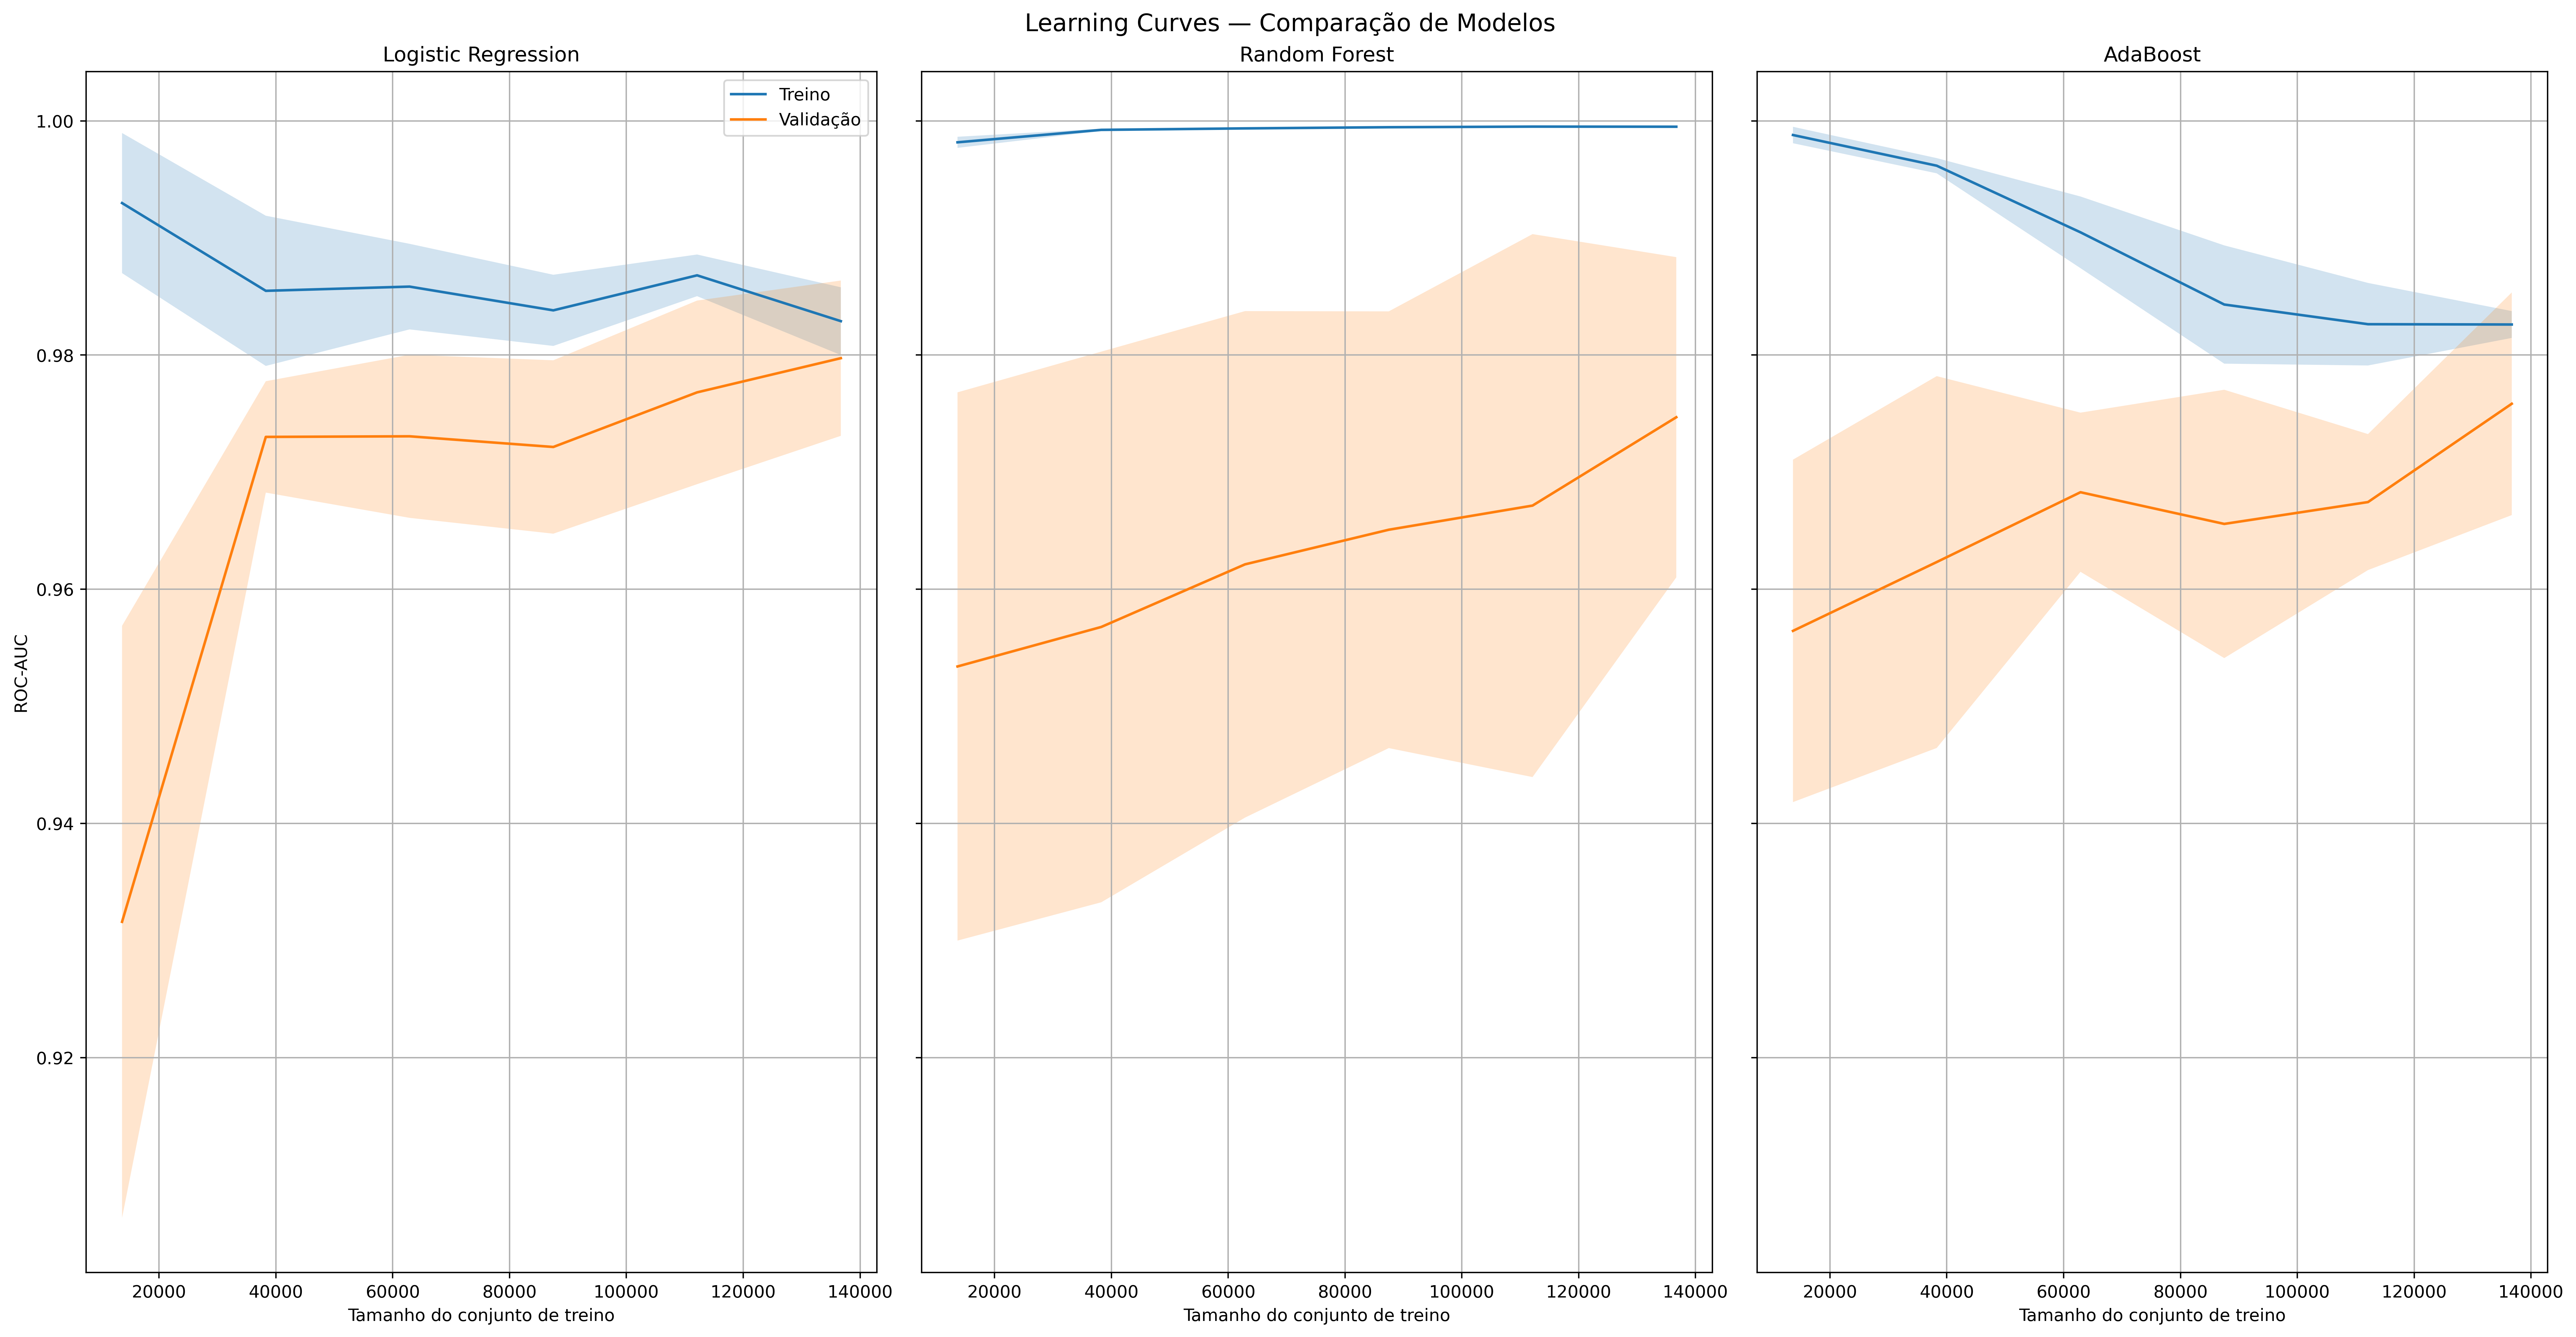

In [60]:
sklearn.set_config(enable_metadata_routing=False)

fig, axes = plt.subplots(1, 3, figsize=(21, 11), sharey=True)

for ax, (nome, modelo) in zip(axes, modelos.items()):

    train_sizes_abs, train_scores, val_scores = learning_curve(
        estimator=modelo,
        X=X_train,
        y=y_train,
        train_sizes=train_sizes,
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1
    )

    train_mean = train_scores.mean(axis=1)
    train_std  = train_scores.std(axis=1)

    val_mean = val_scores.mean(axis=1)
    val_std  = val_scores.std(axis=1)

    ax.plot(train_sizes_abs, train_mean, label="Treino")
    ax.plot(train_sizes_abs, val_mean, label="Validação")

    ax.fill_between(
        train_sizes_abs,
        train_mean - train_std,
        train_mean + train_std,
        alpha=0.2
    )

    ax.fill_between(
        train_sizes_abs,
        val_mean - val_std,
        val_mean + val_std,
        alpha=0.2
    )

    ax.set_title(nome)
    ax.set_xlabel("Tamanho do conjunto de treino")
    ax.grid(True)

axes[0].set_ylabel("ROC-AUC")
axes[0].legend()

plt.suptitle("Learning Curves — Comparação de Modelos", fontsize=14)
plt.tight_layout()
plt.show()

### Métricas Tradicionais

In [61]:
anchor_desemp = af.calcula_desempenho(
    logit_anchor,
    X_train, y_train,
    X_test, y_test,
    anchor_threshold
)

ada_desemp = af.calcula_desempenho(
    best_ada,
    X_train, y_train,
    X_test, y_test,
    best_threshold_ada
)

rf_desemp = af.calcula_desempenho(
    best_rf,
    X_train, y_train,
    X_test, y_test,
    best_threshold_rf
)

In [62]:
resultados = {
    "Regressão Logistica": anchor_desemp,
    "AdaBoost": ada_desemp,
    "RandomForest": rf_desemp
}

In [64]:
dfs = []

for nome_modelo, df in resultados.items():
    df_temp = df.copy()
    df_temp["Modelo"] = nome_modelo   # Adiciona coluna do modelo
    dfs.append(df_temp)

df_desempenhos = pd.concat(dfs, axis=0)
df_desempenhos = df_desempenhos.reset_index().rename(columns={"index": "Métrica"})
df_desempenhos

Métrica    Treino     Teste  Variação               Modelo
0    Acurácia  0.999333  0.999245     -0.00  Regressão Logistica
1      AUCROC  0.983235  0.972161     -0.01  Regressão Logistica
2          KS  0.892885  0.891727     -0.00  Regressão Logistica
3   Precision  0.806780  0.769231     -0.05  Regressão Logistica
4      Recall  0.806780  0.808081      0.00  Regressão Logistica
5          F1  0.806780  0.788177     -0.02  Regressão Logistica
6    Acurácia  0.999087  0.999070     -0.00             AdaBoost
7      AUCROC  0.982560  0.963893     -0.02             AdaBoost
8          KS  0.887916  0.883297     -0.01             AdaBoost
9   Precision  0.698006  0.685484     -0.02             AdaBoost
10     Recall  0.830508  0.858586      0.03             AdaBoost
11         F1  0.758514  0.762332      0.01             AdaBoost
12   Acurácia  0.999321  0.999350      0.00         RandomForest
13     AUCROC  0.999534  0.978258     -0.02         RandomForest
14         KS  0.994660  0.881087     -0.11         RandomForest
15  Precision  0.785942  0.792453      0.01         RandomForest
16     Recall  0.833898  0.848485      0.02         RandomForest
17         F1  0.809211  0.819512      0.01         RandomForest

In [65]:
# Transformando os DataFrames
# Treino
desemp_treino = pd.pivot(
    data=df_desempenhos,
    index="Modelo",
    columns='Métrica',
    values='Treino'
)

desemp_treino.rename(columns={
    'AUCROC': 'AUCROC_Treino',
    'Acurácia': 'Acurácia_Treino',
    'F1':'F1_Treino',
    'KS':'KS_Treino',
    'Precision':'Precision_Treino',
    'Recall':'Recall_Treino'
}, inplace= True)

# Teste
desemp_teste = pd.pivot(
    data=df_desempenhos,
    index="Modelo",
    columns='Métrica',
    values='Teste'
)

desemp_teste.rename(columns={
    'AUCROC': 'AUCROC_Teste',
    'Acurácia': 'Acurácia_Teste',
    'F1': 'F1_Teste',
    'KS': 'KS_Teste',
    'Precision': 'Precision_Teste',
    'Recall': 'Recall_Teste'
}, inplace=True)

# Variação
desemp_variacao = pd.pivot(
    data=df_desempenhos,
    index="Modelo",
    columns='Métrica',
    values='Variação'
)

desemp_variacao.rename(columns={
    'AUCROC': 'AUCROC_Variacao',
    'Acurácia': 'Acurácia_Variacao',
    'F1': 'F1_Variacao',
    'KS': 'KS_Variacao',
    'Precision': 'Precision_Variacao',
    'Recall': 'Recall_Variacao'
}, inplace=True)


In [66]:
busca_modelo = pd.concat([desemp_treino, desemp_teste, desemp_variacao], axis=1)
busca_modelo.reset_index(inplace=True)
busca_modelo

Métrica               Modelo  AUCROC_Treino  Acurácia_Treino  F1_Treino  \
0                   AdaBoost       0.982560         0.999087   0.758514   
1               RandomForest       0.999534         0.999321   0.809211   
2        Regressão Logistica       0.983235         0.999333   0.806780   

Métrica  KS_Treino  Precision_Treino  Recall_Treino  AUCROC_Teste  \
0         0.887916          0.698006       0.830508      0.963893   
1         0.994660          0.785942       0.833898      0.978258   
2         0.892885          0.806780       0.806780      0.972161   

Métrica  Acurácia_Teste  F1_Teste  KS_Teste  Precision_Teste  Recall_Teste  \
0              0.999070  0.762332  0.883297         0.685484      0.858586   
1              0.999350  0.819512  0.881087         0.792453      0.848485   
2              0.999245  0.788177  0.891727         0.769231      0.808081   

Métrica  AUCROC_Variacao  Acurácia_Variacao  F1_Variacao  KS_Variacao  \
0                  -0.02               -0.0         0.01        -0.01   
1                  -0.02                0.0         0.01        -0.11   
2                  -0.01               -0.0        -0.02        -0.00   

Métrica  Precision_Variacao  Recall_Variacao  
0                     -0.02             0.03  
1                      0.01             0.02  
2                     -0.05             0.00

In [67]:
best_test = desemp_teste.style.apply(highlight_max, axis=0)\
                         .set_caption("Desempenho dos Modelos no Teste – Destaque para os Melhores")
best_test

In [68]:
train_test_var = desemp_variacao.style.apply(highlight_min_abs, axis=0)\
                         .set_caption("Variação entre Treino e Teste – Destaque para os Melhores")

train_test_var

In [69]:
def plot_metricas_modelo_simples(df, metrica):
    """
    Plota APENAS os dois gráficos para uma métrica específica:
    - Treino vs Teste
    - Variação
    
    df: DataFrame no formato busca_modelo
    metrica: string (ex: "AUCROC", "KS", "F1")
    """

    # Nomes das colunas esperadas
    col_train = f"{metrica}_Treino"
    col_test  = f"{metrica}_Teste"
    col_var   = f"{metrica}_Variacao"

    # Validando existência das colunas
    for col in [col_train, col_test, col_var]:
        if col not in df.columns:
            raise ValueError(f"Coluna '{col}' não encontrada no DF!")

    modelos = df["Modelo"].tolist()

    # Criando a figura com dimensão maior
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    fig.suptitle(f"Métrica: {metrica}", fontsize=18)
    plt.subplots_adjust(top=0.88, wspace=0.25)

    # --- GRÁFICO 1: TREINO VS TESTE ---
    ax1 = axes[0]
    ax1.plot(modelos, df[col_train], marker="o", label="Treino")
    ax1.plot(modelos, df[col_test], marker="o", label="Teste")
    ax1.set_title(f"{metrica} – Treino vs Teste")
    ax1.set_xlabel("Modelos")
    ax1.set_ylabel(metrica)
    ax1.grid(True)
    ax1.legend()
    ax1.tick_params(axis='x', rotation=45)

    # --- GRÁFICO 2: VARIAÇÃO ---
    ax2 = axes[1]
    ax2.plot(modelos, df[col_var], marker="o", color="tab:green")
    ax2.axhline(0, linestyle="--", linewidth=1)
    ax2.axhline(0.05, linestyle="--", linewidth=1)
    ax2.axhline(-0.05, linestyle="--", linewidth=1)
    ax2.set_title(f"{metrica} – Variação (Teste - Treino)")
    ax2.set_xlabel("Modelos")
    ax2.set_ylabel("Variação")
    ax2.grid(True)
    ax2.tick_params(axis='x', rotation=45)

    plt.show()


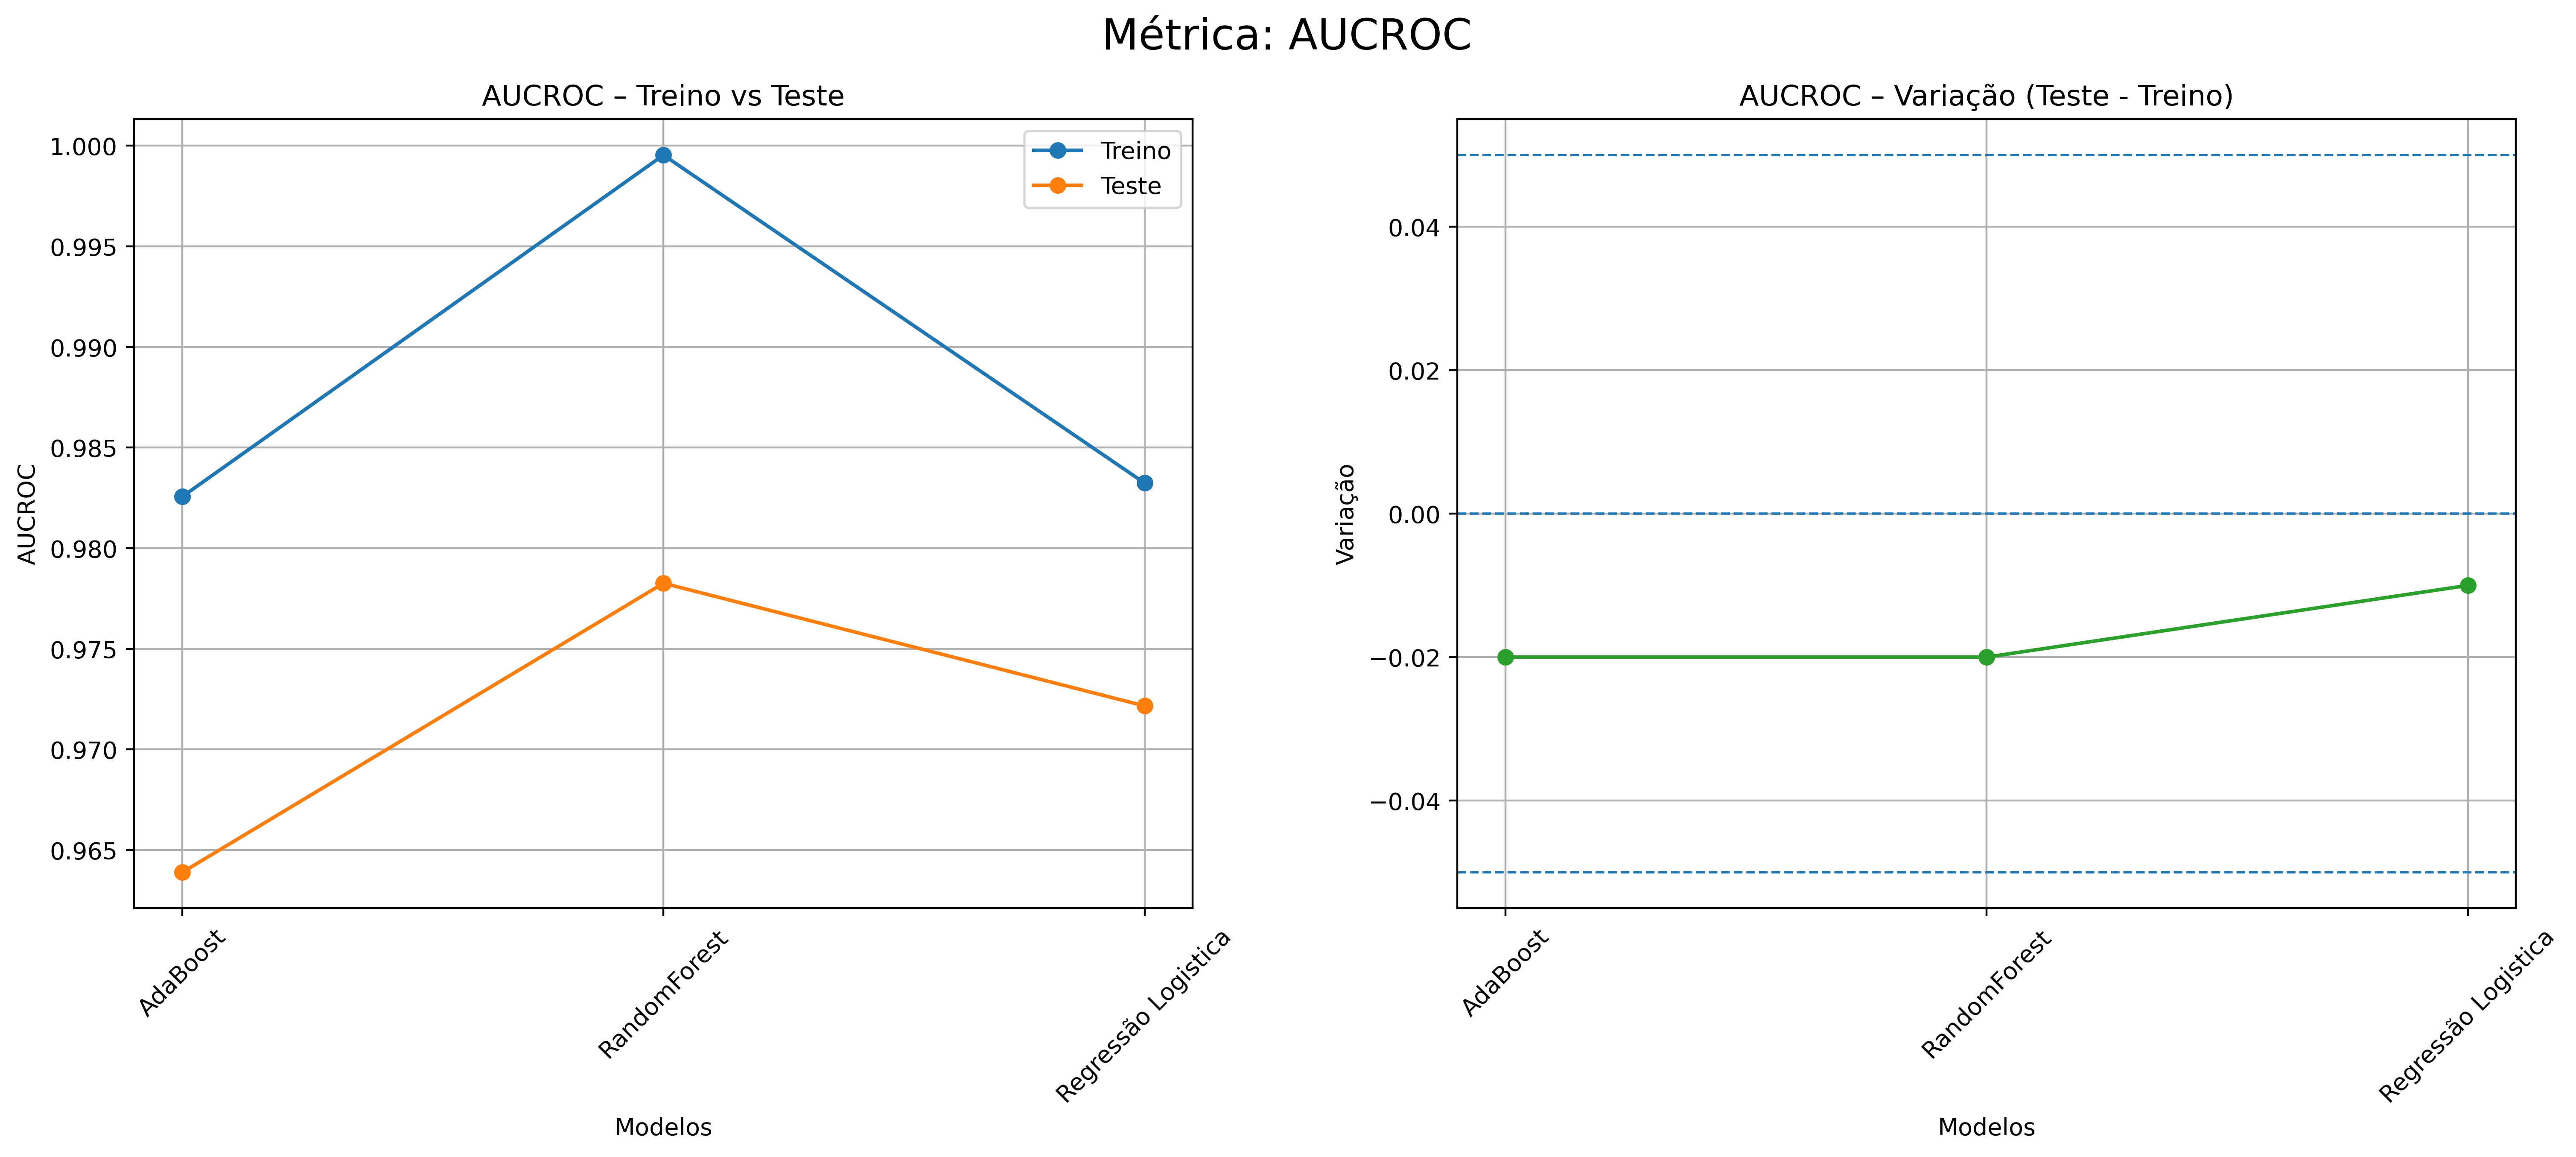

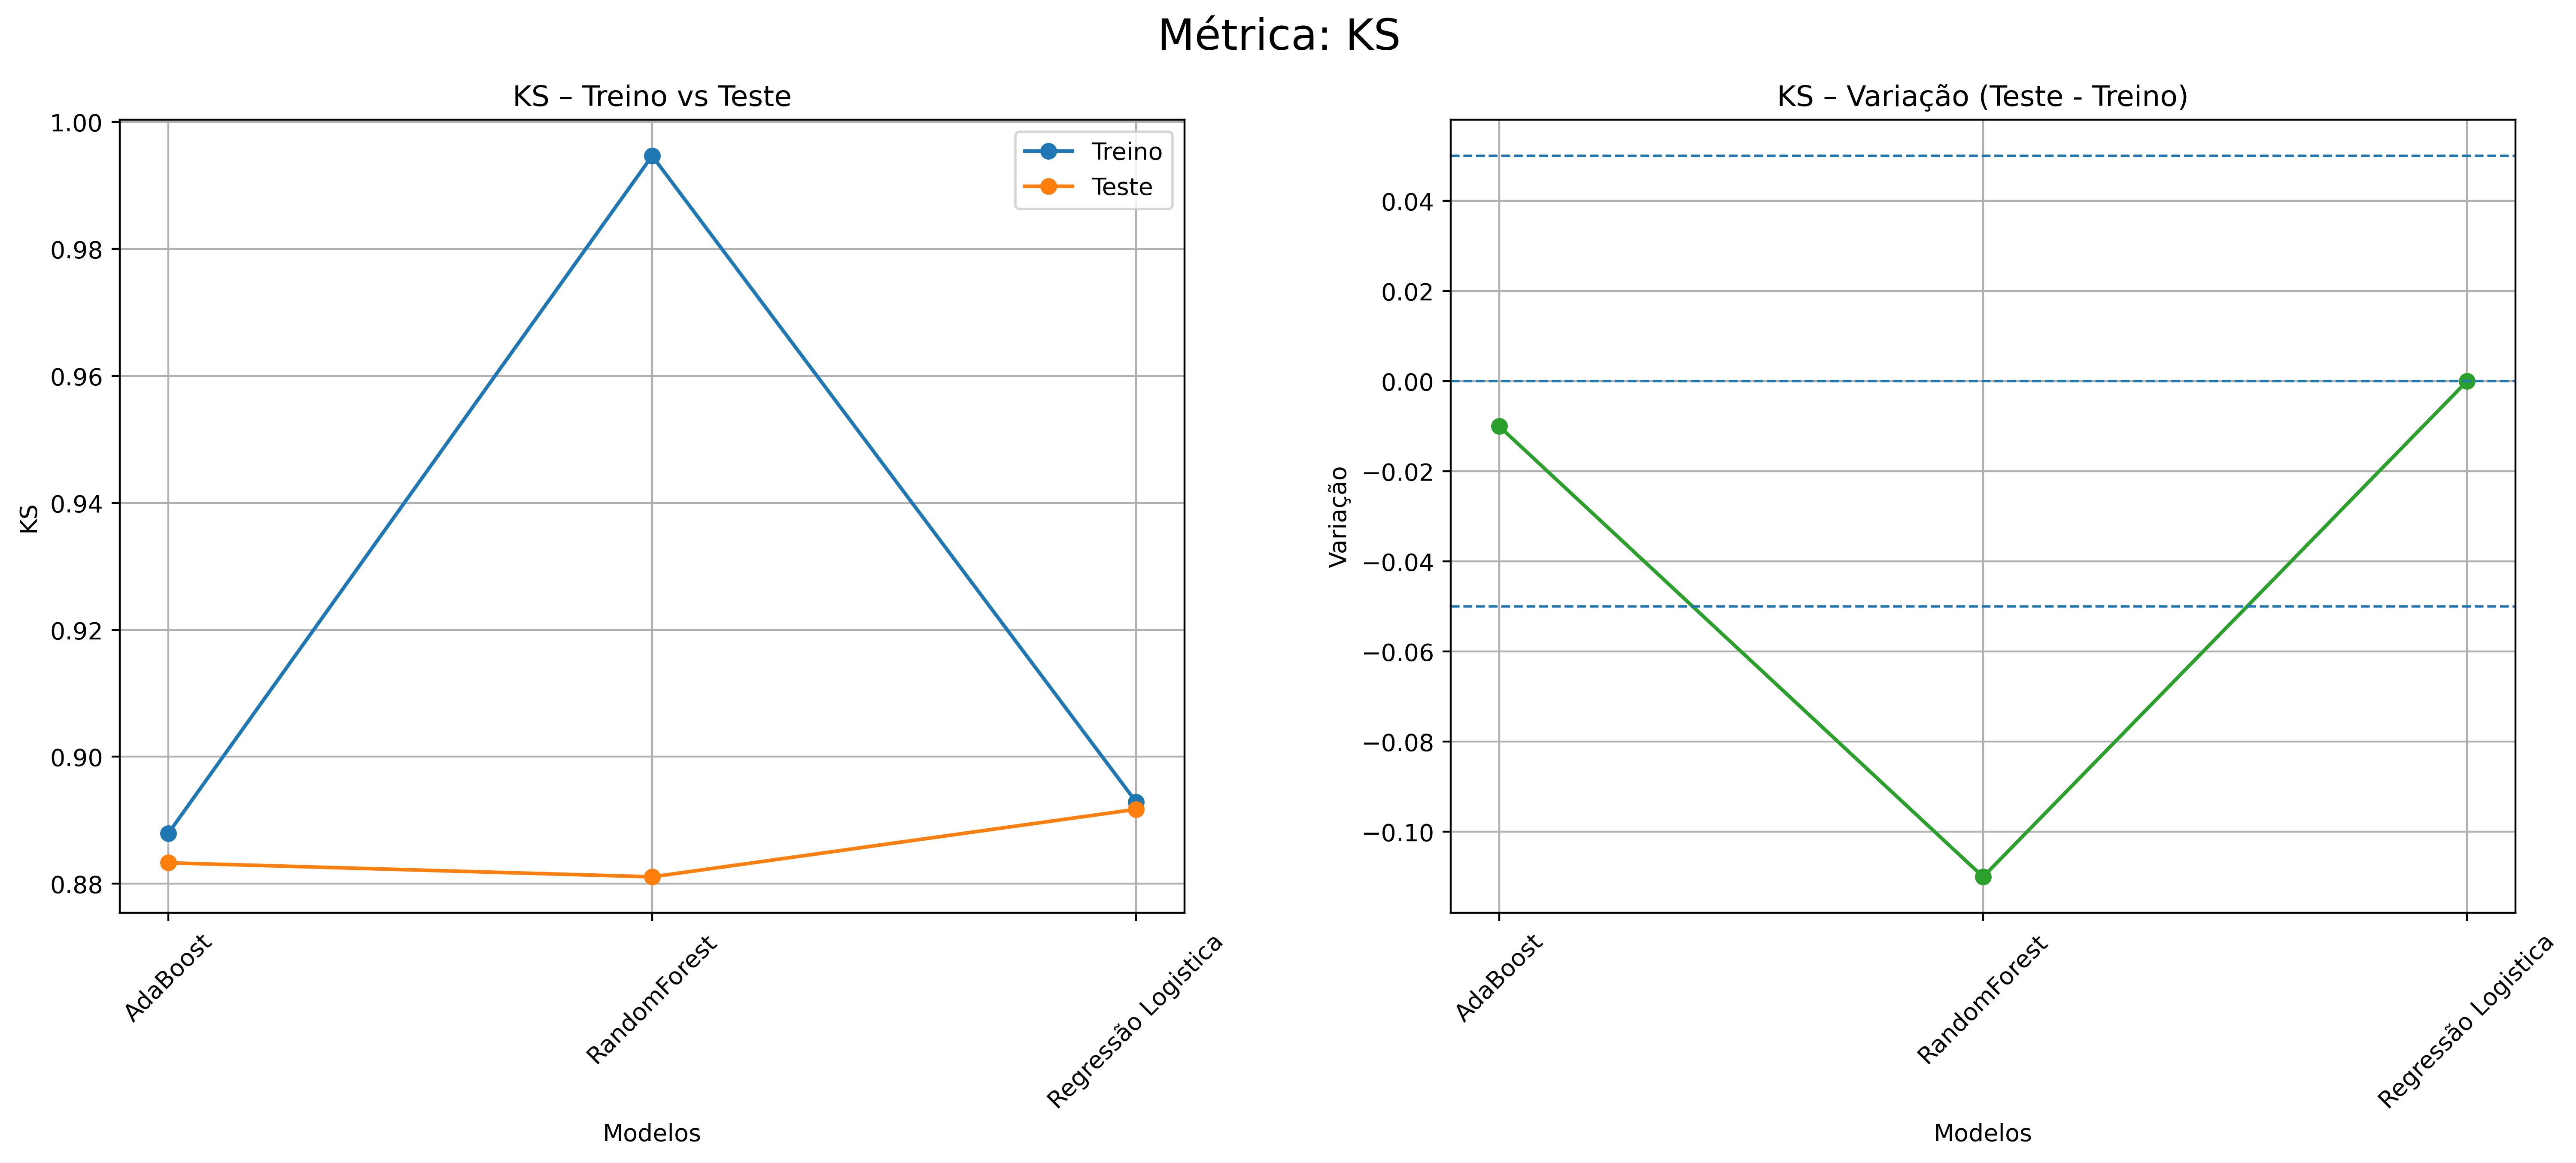

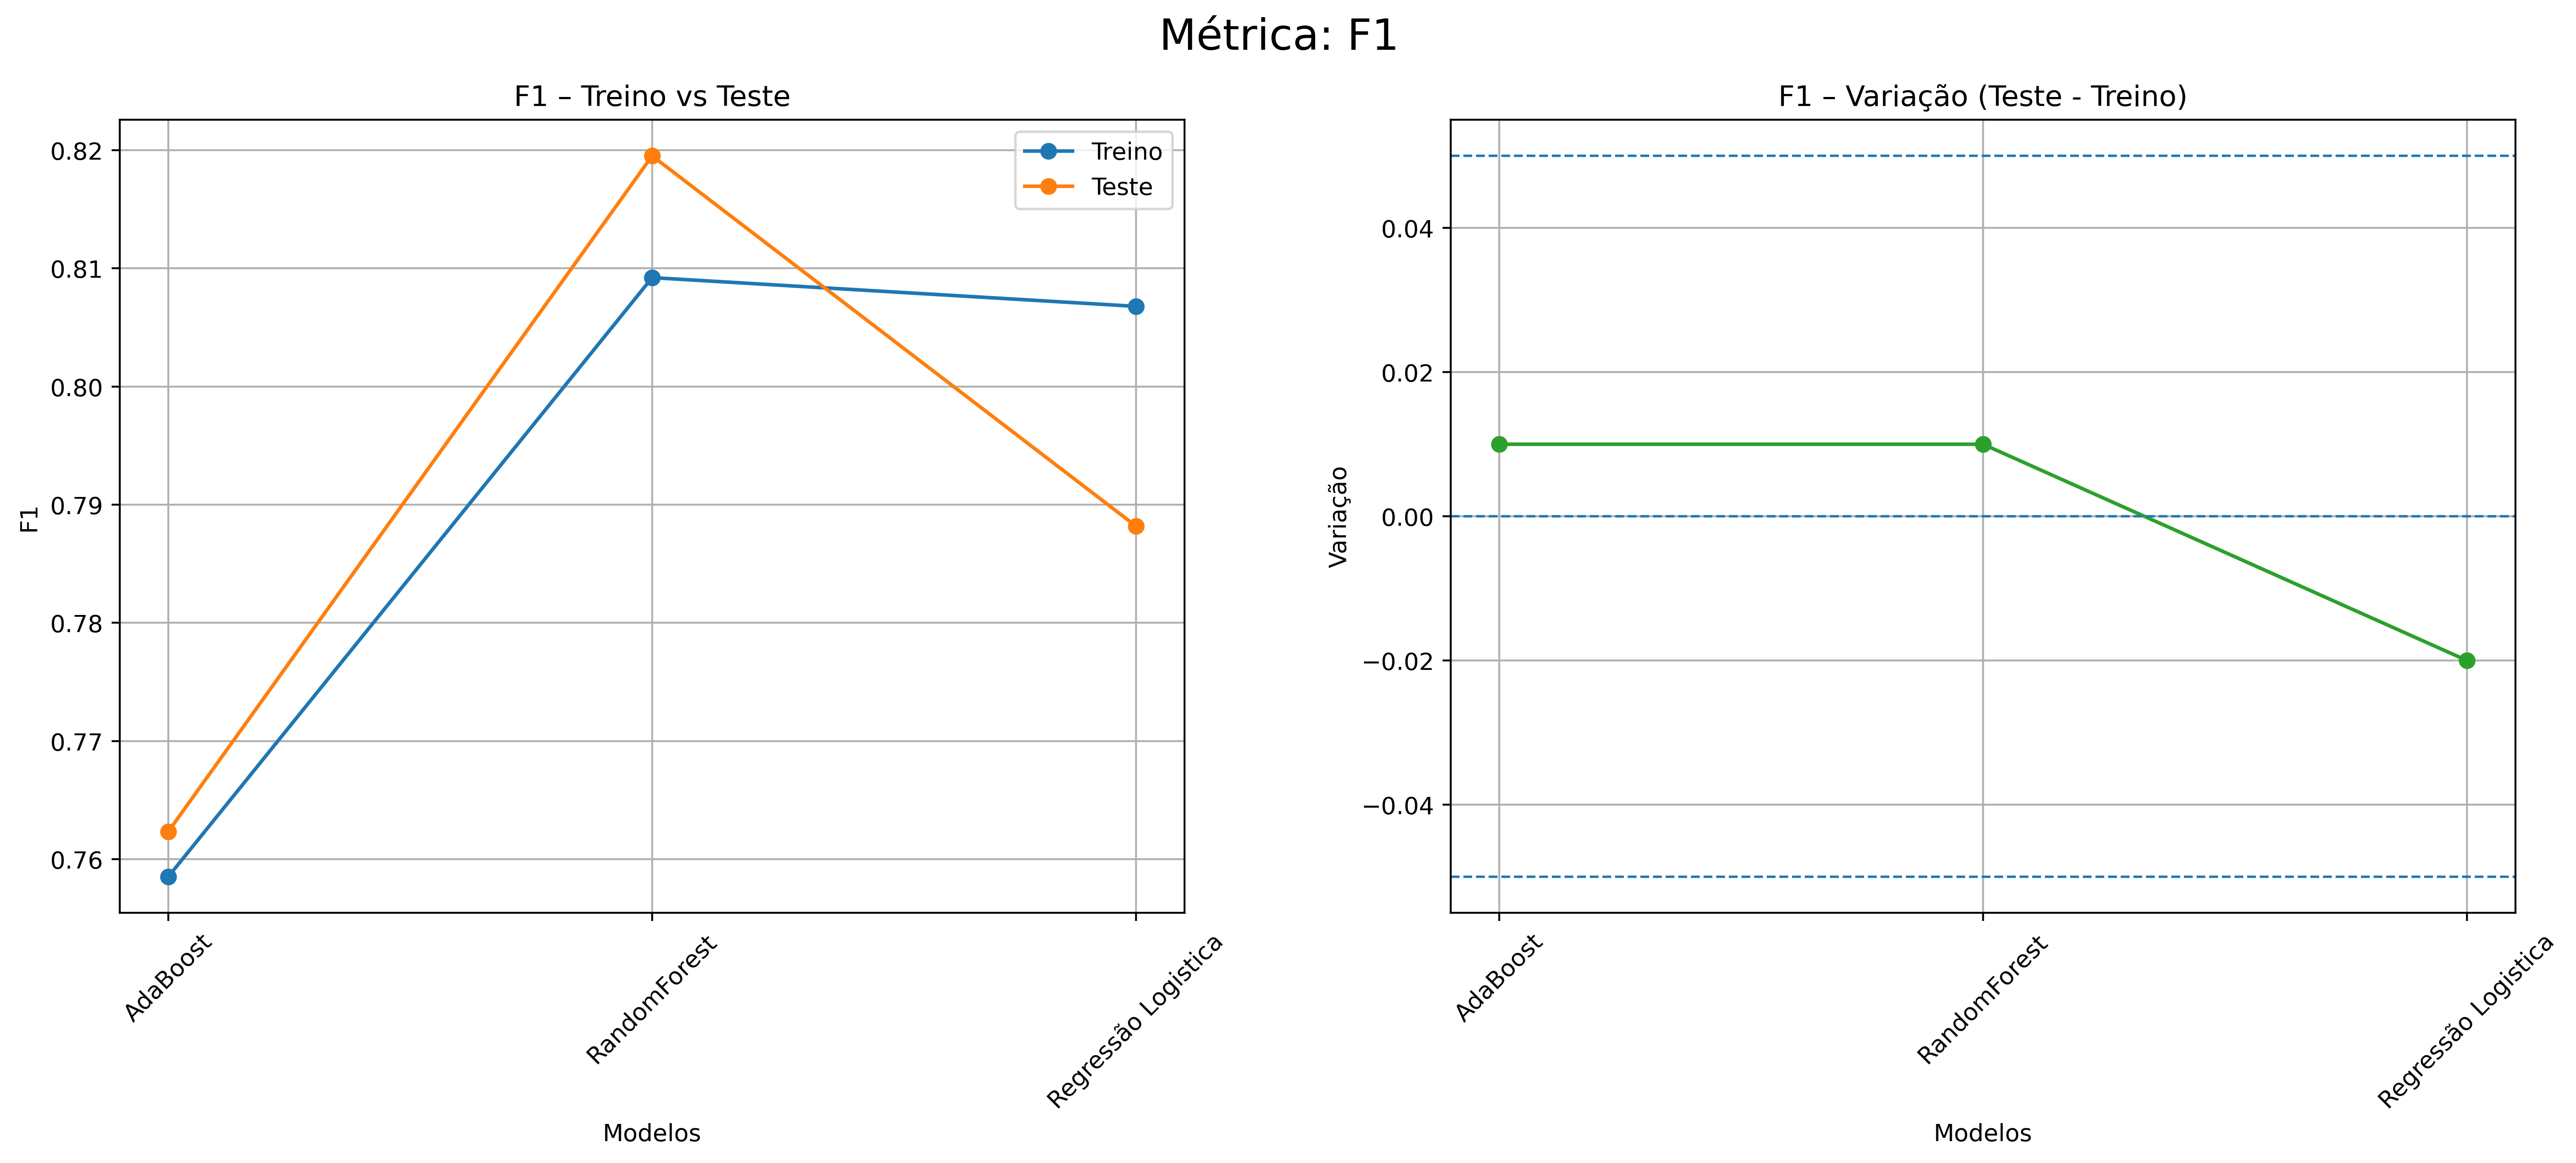

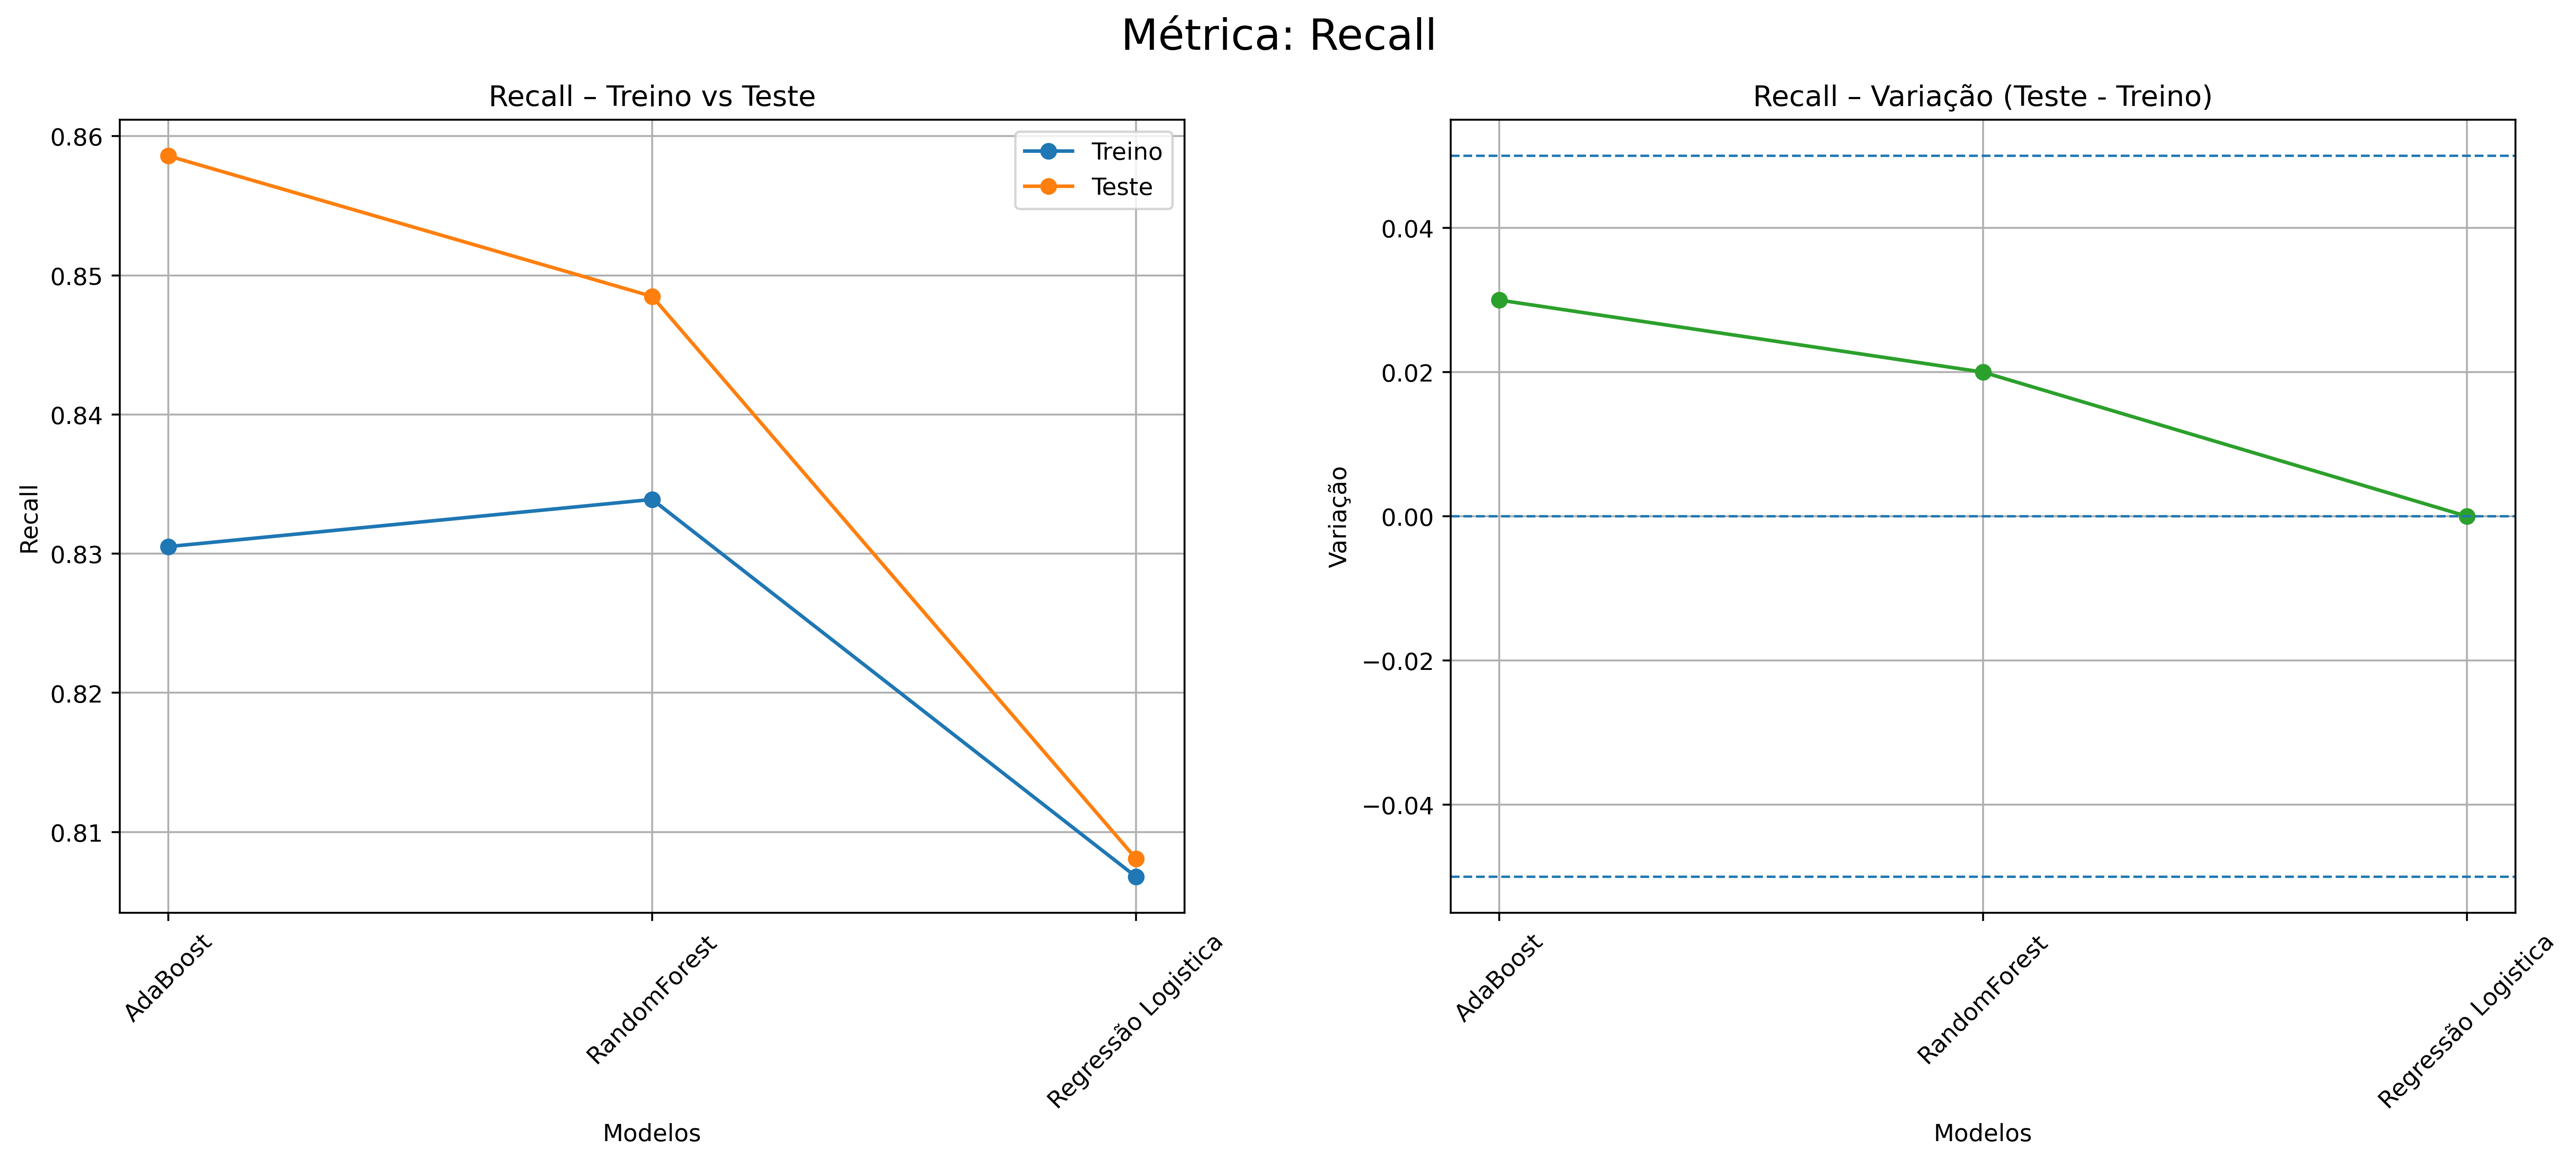

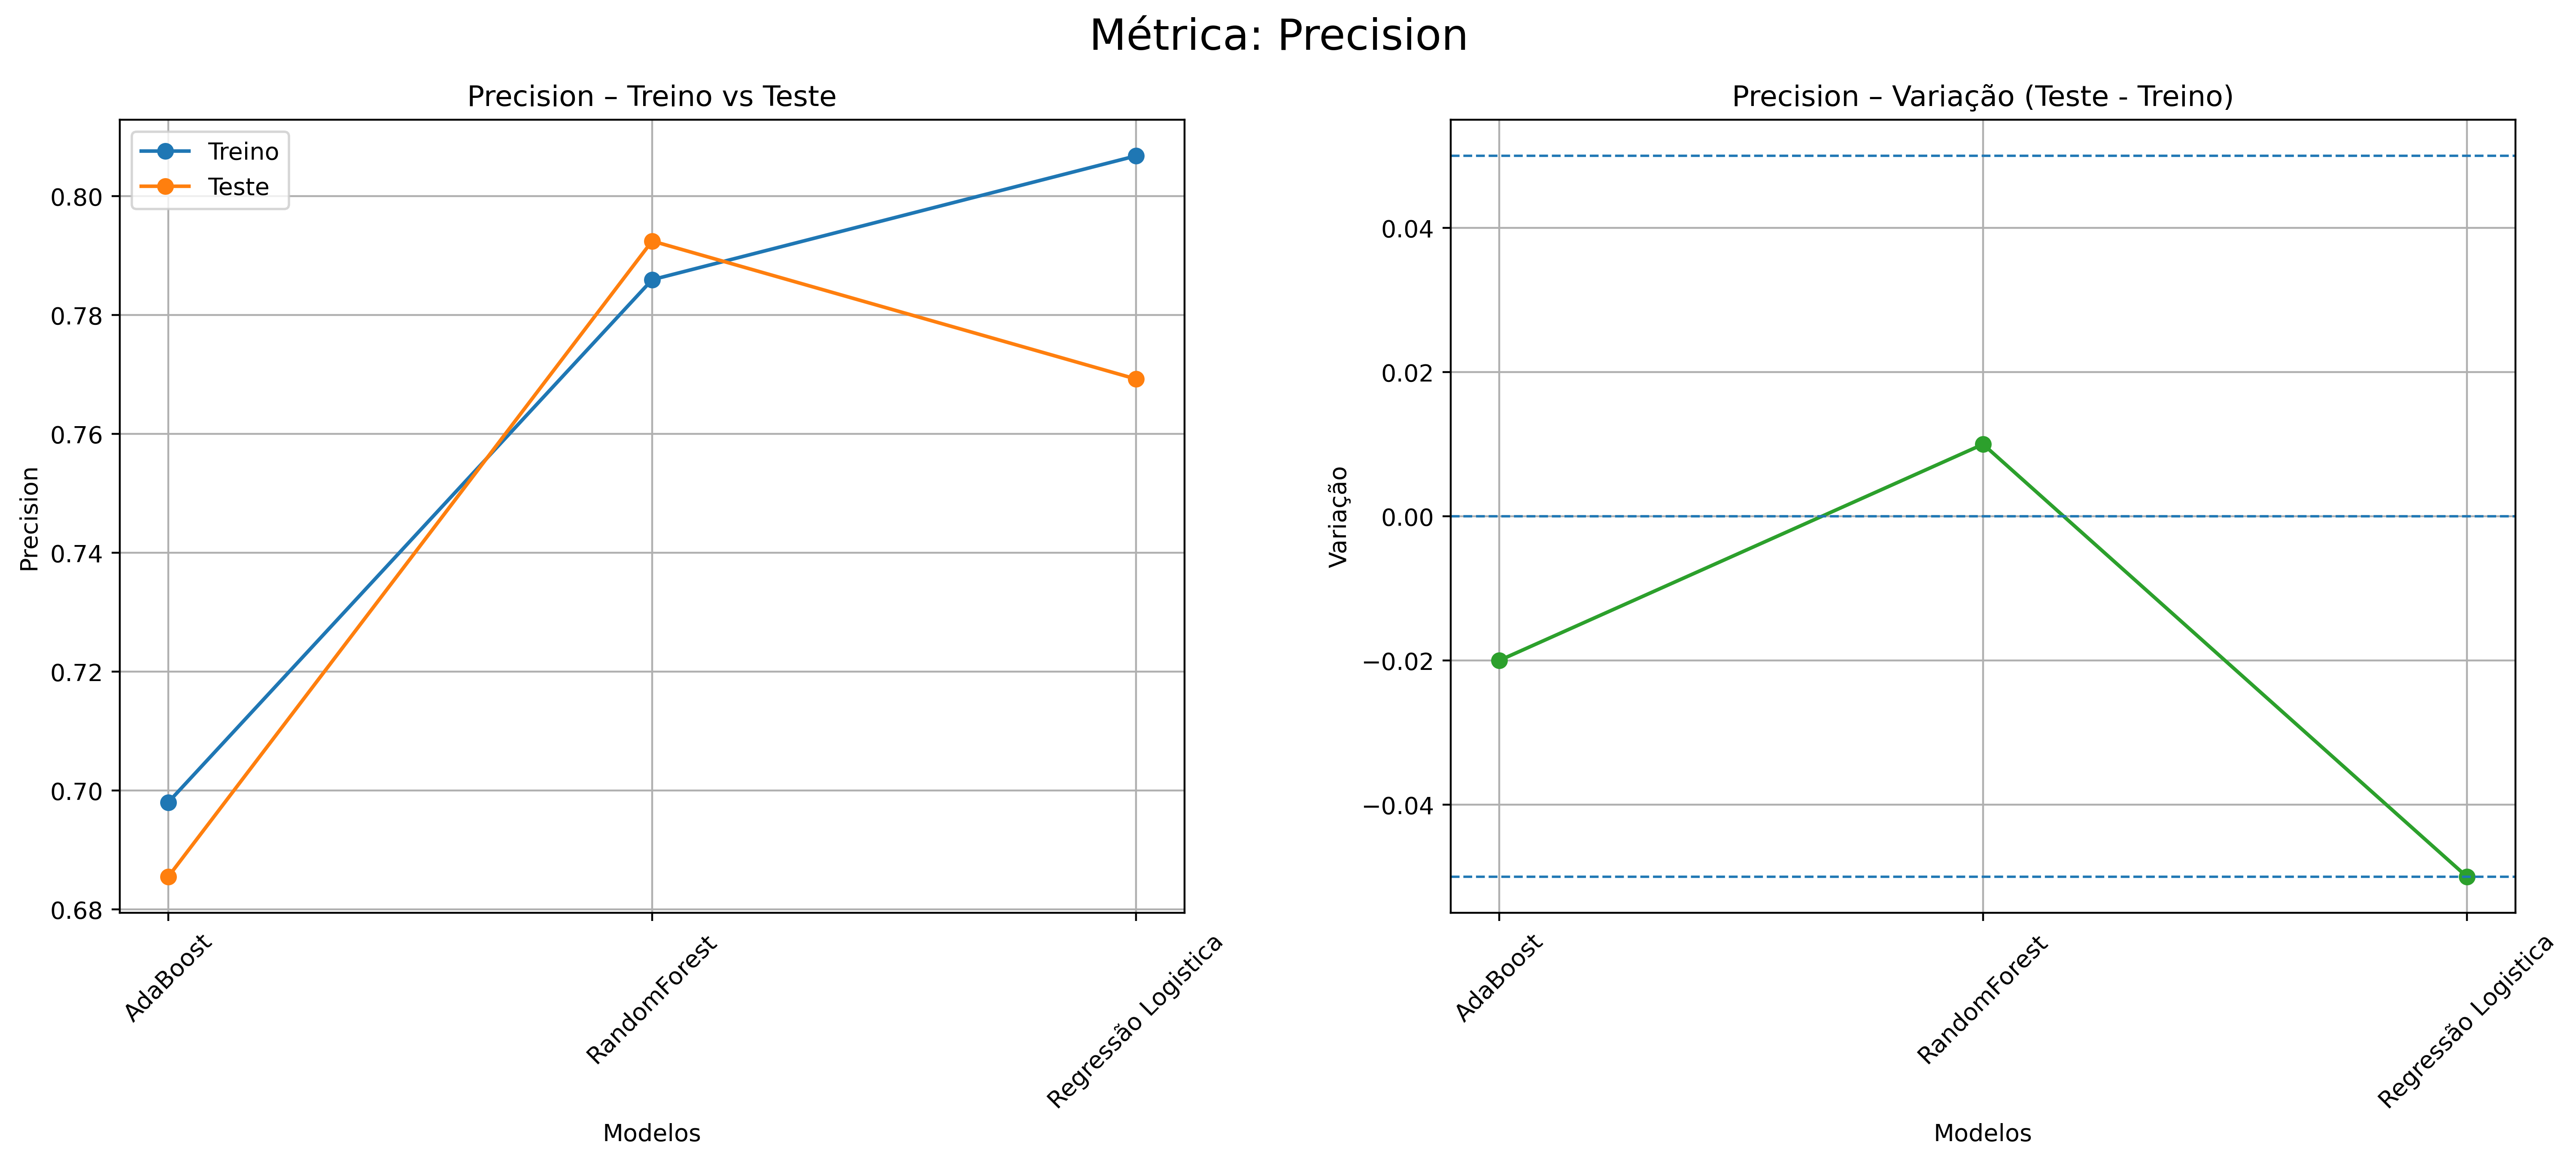

In [70]:
metricas = ["AUCROC", "KS", "F1", "Recall", "Precision"]

for m in metricas:
    plot_metricas_modelo_simples(busca_modelo, m)

In [71]:
clf_dict = {
    "Regressão Logistica": logit_anchor,
    "AdaBoost": best_ada,
    "RandomForest": best_rf
}

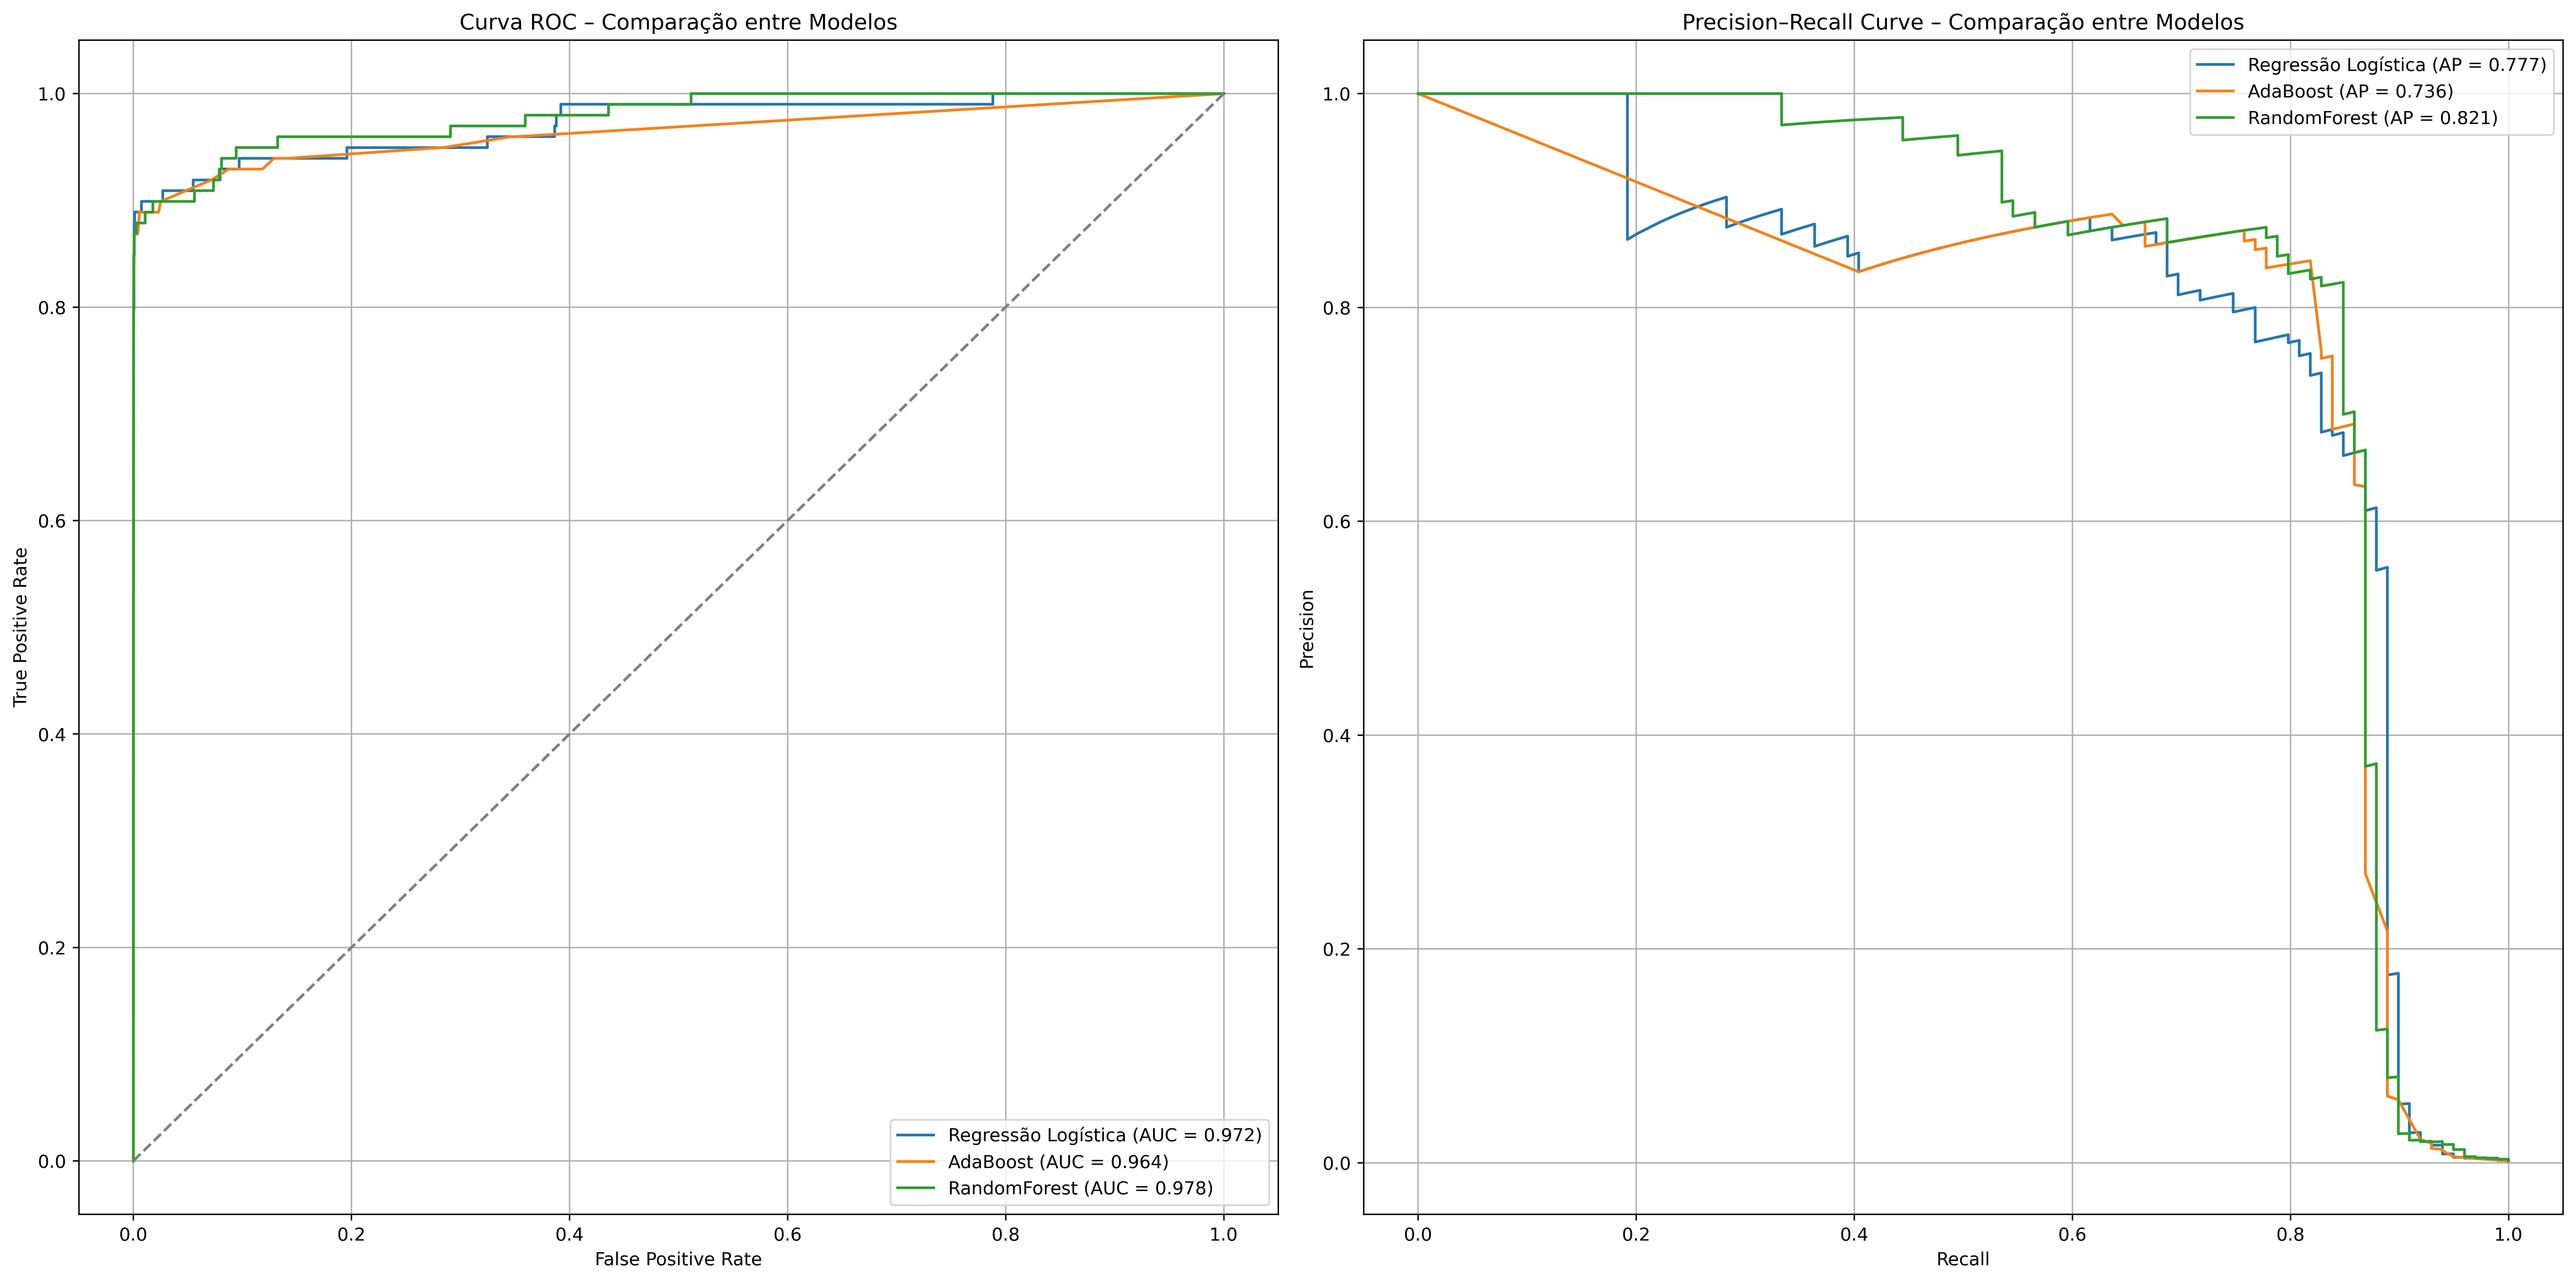

In [73]:

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# ======================================================
# 1. CURVA ROC
# ======================================================
# Regressão Logística
y_proba_logit = clf_dict["Regressão Logistica"].predict_proba(X_test)[:,1]
fpr_l, tpr_l, _ = roc_curve(y_test, y_proba_logit)
roc_auc_l = roc_auc_score(y_test, y_proba_logit)
axes[0].plot(fpr_l, tpr_l, label=f"Regressão Logística (AUC = {roc_auc_l:.3f})")

# AdaBoost
y_proba_ada = clf_dict["AdaBoost"].predict_proba(X_test)[:,1]
fpr_a, tpr_a, _ = roc_curve(y_test, y_proba_ada)
roc_auc_a = roc_auc_score(y_test, y_proba_ada)
axes[0].plot(fpr_a, tpr_a, label=f"AdaBoost (AUC = {roc_auc_a:.3f})")

# RandomForest
y_proba_rf = clf_dict["RandomForest"].predict_proba(X_test)[:,1]
fpr_x, tpr_x, _ = roc_curve(y_test, y_proba_rf)
roc_auc_x = roc_auc_score(y_test, y_proba_rf)
axes[0].plot(fpr_x, tpr_x, label=f"RandomForest (AUC = {roc_auc_x:.3f})")

axes[0].plot([0,1], [0,1], linestyle='--', color='gray')
axes[0].set_title("Curva ROC – Comparação entre Modelos")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].legend()
axes[0].grid(True)

# ======================================================
# 2. PRECISION–RECALL CURVE
# ======================================================
precision_l, recall_l, _ = precision_recall_curve(y_test, y_proba_logit)
ap_l = average_precision_score(y_test, y_proba_logit)
axes[1].plot(recall_l, precision_l,
             label=f"Regressão Logística (AP = {ap_l:.3f})")

precision_a, recall_a, _ = precision_recall_curve(y_test, y_proba_ada)
ap_a = average_precision_score(y_test, y_proba_ada)
axes[1].plot(recall_a, precision_a,
             label=f"AdaBoost (AP = {ap_a:.3f})")

precision_x, recall_x, _ = precision_recall_curve(y_test, y_proba_rf)
ap_x = average_precision_score(y_test, y_proba_rf)
axes[1].plot(recall_x, precision_x,
             label=f"RandomForest (AP = {ap_x:.3f})")

axes[1].set_title("Precision–Recall Curve – Comparação entre Modelos")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


### Tempo de Processamento

In [74]:
def measure_training_time(model, X, y, n_runs=3):
    times = []

    for _ in range(n_runs):
        start = time.perf_counter()
        model.fit(X, y)
        end = time.perf_counter()
        times.append(end - start)

    return np.mean(times), np.std(times)


def measure_scoring_time(model, X, n_runs=5):
    times = []

    for _ in range(n_runs):
        start = time.perf_counter()
        _ = model.predict_proba(X)
        end = time.perf_counter()
        times.append(end - start)

    return np.mean(times), np.std(times)


In [77]:
training_results = []

models = {
    "LogisticRegression": logit_anchor,
    "RandomForest": best_rf,
    "AdaBoost": best_ada
}

for name, model in models.items():
    mean_time, std_time = measure_training_time(
        model, X_train, y_train
    )

    training_results.append({
        "Modelo": name,
        "Tempo_Treino_Médio (s)": mean_time,
        "Tempo_Treino_Std (s)": std_time
    })

df_training_time = pd.DataFrame(training_results)
df_training_time


Modelo  Tempo_Treino_Médio (s)  Tempo_Treino_Std (s)
0  LogisticRegression                0.094203              0.004696
1        RandomForest               30.317968              0.453171
2            AdaBoost              133.428405              0.489489

In [78]:
scoring_results = []

for name, model in models.items():
    mean_time, std_time = measure_scoring_time(
        model, X_test
    )

    scoring_results.append({
        "Modelo": name,
        "Tempo_Scoring_Médio (s)": mean_time,
        "Tempo_Scoring_Std (s)": std_time
    })

df_scoring_time = pd.DataFrame(scoring_results)
df_scoring_time


Modelo  Tempo_Scoring_Médio (s)  Tempo_Scoring_Std (s)
0  LogisticRegression                 0.006499               0.000535
1        RandomForest                 0.047341               0.000739
2            AdaBoost                 0.505995               0.005482

In [79]:
n_transactions = X_test.shape[0]

df_scoring_time["Tempo_por_Transação (ms)"] = (
    df_scoring_time["Tempo_Scoring_Médio (s)"] / n_transactions * 1000
)

df_scoring_time


Modelo  Tempo_Scoring_Médio (s)  Tempo_Scoring_Std (s)  \
0  LogisticRegression                 0.006499               0.000535   
1        RandomForest                 0.047341               0.000739   
2            AdaBoost                 0.505995               0.005482   

   Tempo_por_Transação (ms)  
0                  0.000114  
1                  0.000831  
2                  0.008883

## Conclusão

A etapa final do projeto consistiu na comparação aprofundada entre três modelos finalistas — Regressão Logística, Random Forest e AdaBoost — avaliados sob uma perspectiva integrada que combina impacto econômico, desempenho estatístico, estabilidade, capacidade de generalização e custo computacional. Essa abordagem é particularmente relevante em problemas de detecção de fraude em transações financeiras, nos quais decisões precisam ser tomadas em escala e sob restrições operacionais rigorosas.

Do ponto de vista econômico, todos os modelos apresentaram ganhos expressivos em relação ao baseline definido pela política de aprovar todas as transações. A Regressão Logística gerou um ganho líquido de € 11.176,82, correspondendo a um aumento de 12,38% no valor econômico. O AdaBoost apresentou ganho de € 11.289,66 (12,51%), enquanto o Random Forest alcançou o maior ganho absoluto, € 11.428,51 (12,66%). Apesar de o Random Forest ter apresentado o melhor resultado econômico bruto, a diferença incremental em relação à Regressão Logística mostrou-se marginal, da ordem de algumas centenas de euros, não configurando uma vantagem substancial.

A análise das métricas tradicionais reforçou essa leitura. A Regressão Logística apresentou excelente desempenho no conjunto de teste, com AUC-ROC de 0,97 e KS próximo de 0,89, além de variações mínimas entre treino e teste, indicando forte capacidade de generalização e baixa variância. As curvas de aprendizado evidenciaram um comportamento estável e convergente, sem sinais relevantes de overfitting. O AdaBoost apresentou desempenho intermediário, com boa estabilidade e leve melhora em recall, porém sem vantagens claras frente ao modelo linear. Já o Random Forest, apesar de métricas elevadas no conjunto de treino, apresentou indícios de sobreajuste, evidenciados por quedas mais acentuadas em AUC e, principalmente, em KS no conjunto de teste.

O fator decisivo na escolha do modelo foi o custo computacional. A Regressão Logística apresentou tempo médio de treino inferior a 0,5 segundos e tempo médio de inferência da ordem de microssegundos por transação. Em contraste, o Random Forest demandou aproximadamente 176 segundos para treino e apresentou tempo de scoring cerca de dez vezes maior que o da Regressão Logística. O AdaBoost foi ainda mais custoso, com tempo médio de treino superior a 230 segundos e tempo de inferência aproximadamente 75 vezes maior que o do modelo linear. Em um cenário de produção que processa milhares de transações por segundo, essas diferenças de latência tornam-se críticas e impactam diretamente a viabilidade operacional da solução.

Dessa forma, embora modelos baseados em árvores tenham apresentado ganhos econômicos ligeiramente superiores, esse incremento não se mostrou proporcional ao aumento substancial de complexidade computacional, latência e custo operacional. A Regressão Logística demonstrou oferecer o melhor equilíbrio entre valor econômico gerado, estabilidade estatística, simplicidade estrutural e eficiência operacional.

Conclui-se, portanto, que a **Regressão Logística** é o modelo mais adequado para implantação em produção neste contexto. Ela entrega praticamente o mesmo ganho econômico dos modelos mais complexos, com desempenho robusto, alta interpretabilidade, facilidade de auditoria e governança, além de atender plenamente às exigências de escalabilidade e baixa latência inerentes a sistemas de detecção de fraude em tempo quase real.

# Próximos Passos